# Finding star positions 

In [1]:
%pylab notebook
%matplotlib notebook

import os, glob

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import rawpy
from astropy.table import Table
from astropy.io import fits
import photutils

Populating the interactive namespace from numpy and matplotlib


## Read and normalize image

Start with last image in sequence. The last images have the highest exposure setting. This should make it easier for the star-finding algorithms to work. It also places every image in the sequence on the same side of the temporal sequence (shouldn't be a limiting factor though).

In [2]:
# read image file
path = '../astrophotography_data/MilkyWayPrettyBoy/'
list_p = glob.glob(os.path.join(path,'12800/light/*.ARW'))
fname = list_p[-1] # last

raw = rawpy.imread(fname)

In [3]:
# debayer
rgb = raw.postprocess(
    demosaic_algorithm=rawpy.DemosaicAlgorithm.LINEAR,
    output_bps=16,
    gamma=(1,1), 
    use_camera_wb=False,
    use_auto_wb=False,
    no_auto_bright=True, 
    no_auto_scale=True,
    output_color=rawpy.ColorSpace.raw
)

red = rgb[::,::,0]
green = rgb[::,::,1]
blue = rgb[::,::,2]

Flat image was created by notebook Flat_analysis_1.ipynb

In [4]:
# read and normalize flat image (use this specific flat image)
flat_name = os.path.join(path, '12800/light/flat_raw_2.fits') 
hdul = fits.open(flat_name)
flat_red = hdul[1].data
flat_green = hdul[2].data
flat_blue = hdul[3].data

flat_red /= np.max(flat_red) 
flat_green /= np.max(flat_green)
flat_blue /= np.max(flat_blue) 

In [5]:
# normalize bands
norm_red = red / flat_red
norm_green = green / flat_green
norm_blue = blue / flat_blue

<IPython.core.display.Javascript object>


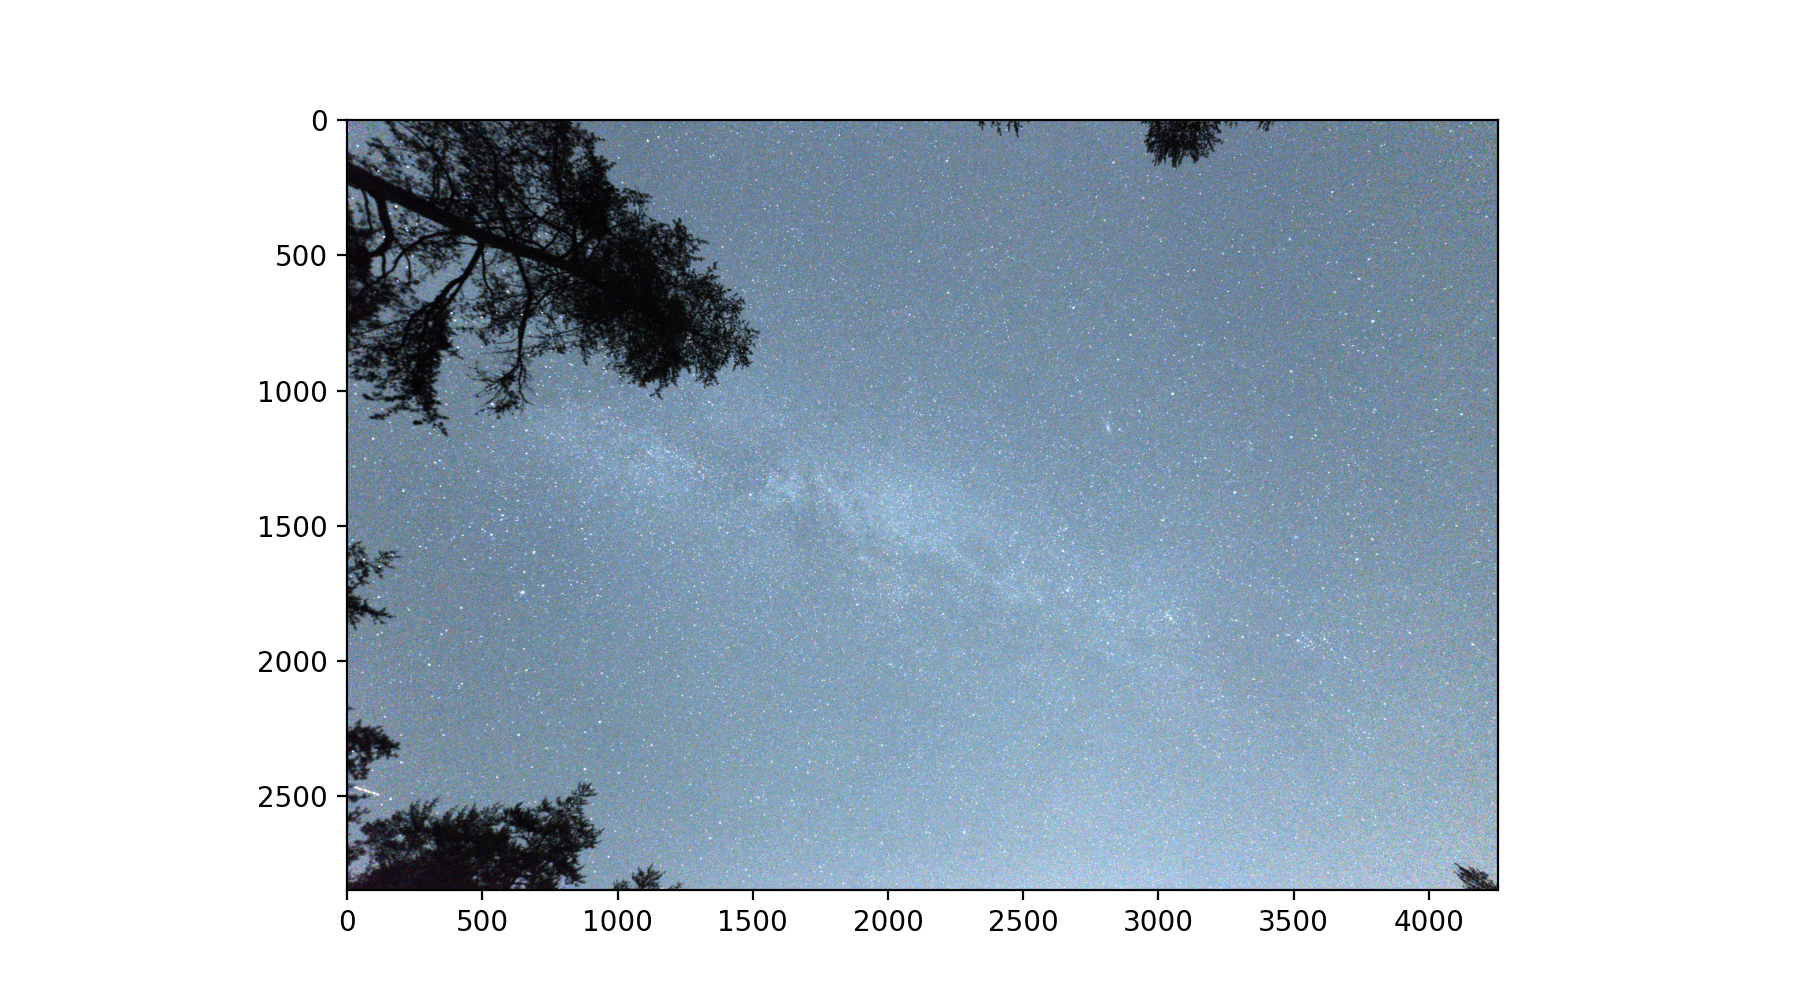

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [6]:
# Check result by reassembling bands into RGB image. Scale to fit matplotlib limits.
norm_rgb_scaled = np.zeros(shape=(red.shape[0],red.shape[1],3))

norm_factor = max(np.max(norm_red), np.max(norm_green), np.max(norm_blue))

norm_rgb_scaled[::,::,0] = norm_red / norm_factor * 60 * 1.2
norm_rgb_scaled[::,::,1] = norm_green / norm_factor * 30 * 1.4
norm_rgb_scaled[::,::,2] = norm_blue / norm_factor * 60 * 1.3

plt.figure(figsize=[9, 5])
plt.imshow(norm_rgb_scaled)

<IPython.core.display.Javascript object>


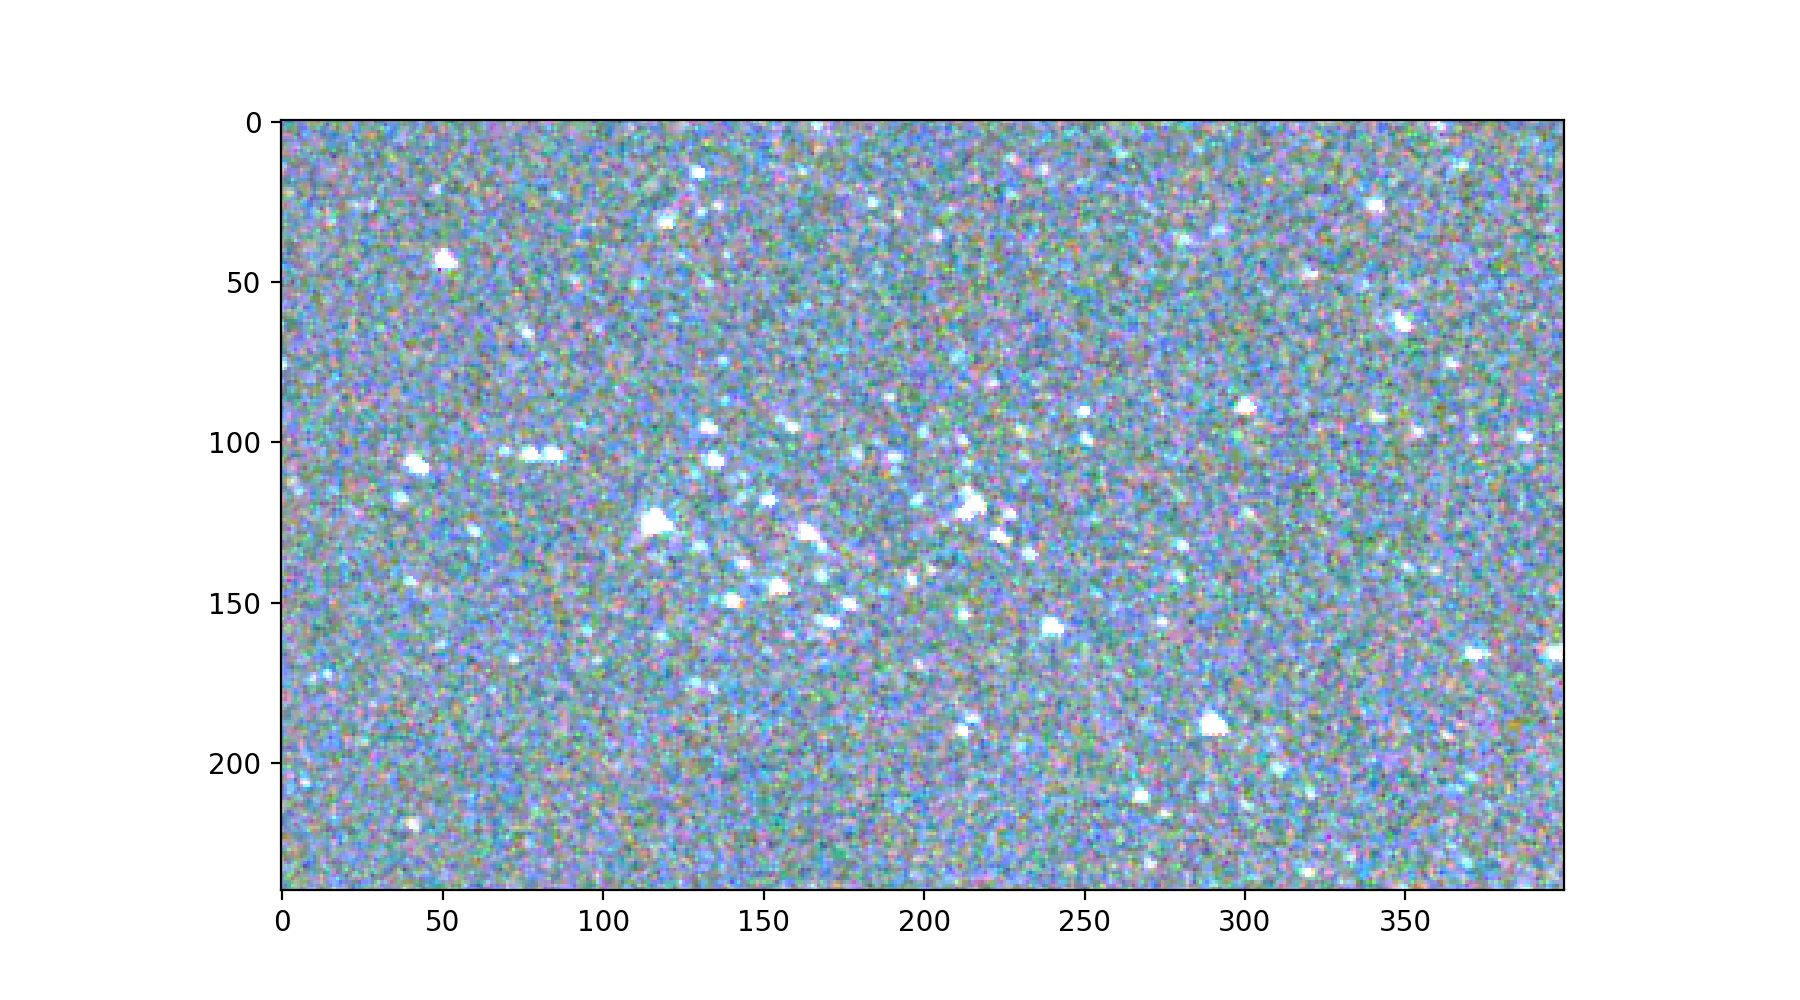

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [7]:
plt.figure(figsize=[9, 5])
plt.imshow(norm_rgb_scaled[1800:2040,3400:3800])

## Alternative procedure: combine RGB with weights

Instead of debayering, use the raw RGB array directly. Each band needs to be normalized with an appropriate factor that should create, ideally, star images that are well behaved. That is, the different gains associated with each band must be accounted for so star images are represented by smooth peaks, and the background should look smooth (separate RGB pixels carry a similar signal to each other).

In a way, an image built in this way can be regarded as a type of black-and-white image.

In [8]:
# masks that isolate the RGB pixels 
colors_array = raw.raw_colors_visible
mask = np.ones(shape=colors_array.shape)

red_mask = np.where(colors_array == 0, 1, 0)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = green_mask_1 | green_mask_2

blue_mask = np.where(colors_array == 2, 1, 0)

In [9]:
# band normalization factors
# red_norm = 1.16666 * 0.8
red_norm = 1.4 * 0.8
green_norm = 1.0 * 0.8
blue_norm = 1.07692 * 0.8

# factors defined based on Spectral_correction notebook
# red_norm = 2.303
# green_norm = 1.
# blue_norm = 1.529

# normalize by flat
imarray = np.copy(raw.raw_image_visible)

# masked flats are full of zeroed pixels. Use inverse instead.
flat_red_inv = np.ones_like(flat_red) / flat_red
flat_green_inv = np.ones_like(flat_green) / flat_green
flat_blue_inv = np.ones_like(flat_blue) / flat_blue

# these will cause the flat to be disregarded
flat_red_inv = np.ones_like(flat_red) 
flat_green_inv = np.ones_like(flat_green) 
flat_blue_inv = np.ones_like(flat_blue) 

raw_norm_1 = imarray * (flat_red_inv * red_mask * red_norm)
raw_norm_2 = raw_norm_1 + imarray * (flat_green_inv * green_mask * green_norm)
raw_norm = raw_norm_2 + imarray * (flat_blue_inv * blue_mask * blue_norm)

The normalization factors above where chosen based on work in the flat analysis notebook, plus the fact that they seem to generate the smoothest result.

The factors defined by RGB band integration with a solar spectrum are off. Need to find out why. 

<IPython.core.display.Javascript object>


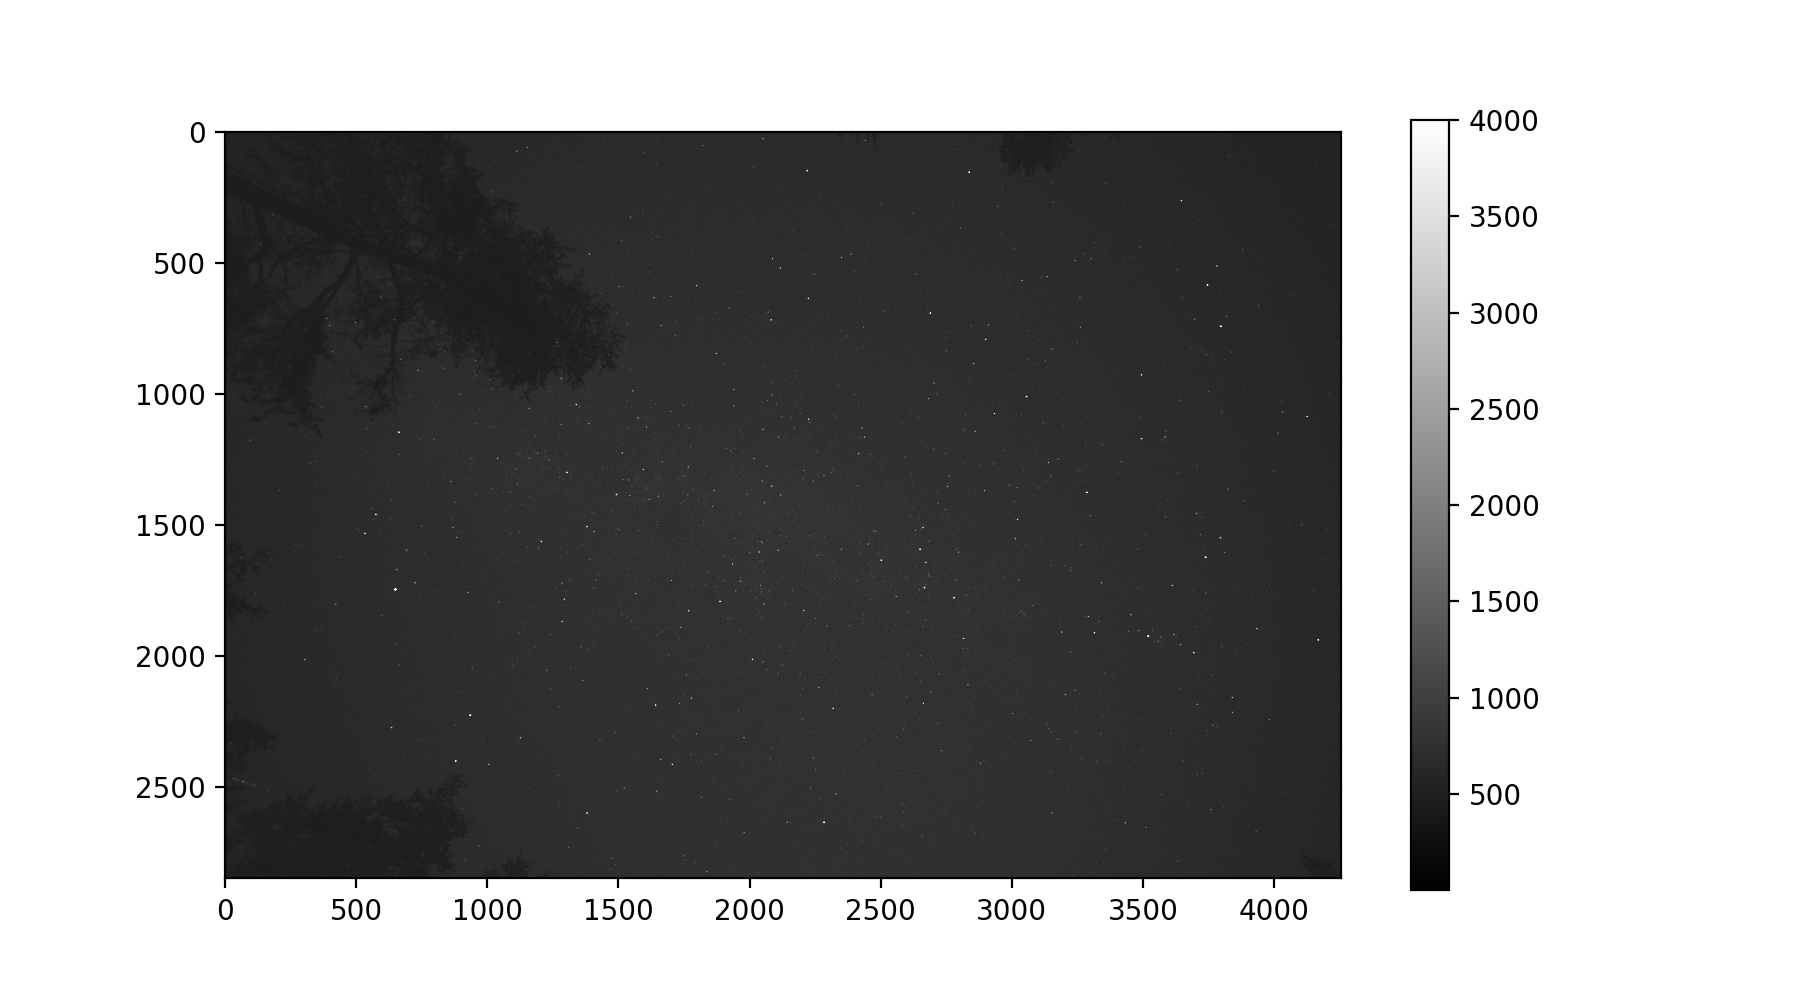

18348.96


In [10]:
plt.figure(figsize=[9, 5])
print(np.max(raw_norm))
plt.imshow(raw_norm, vmax=4000, cmap='gray')
plt.colorbar()

### Handle saturated pixels

If left unchecked, contiguous saturated pixels will result in a checkered pattern in the normalized image, because each band is multiplied by a different factor. 

We can fix this by forcing saturated pixels to be constant. This is not good for photometry, but for finding star centers should work fine.

<IPython.core.display.Javascript object>


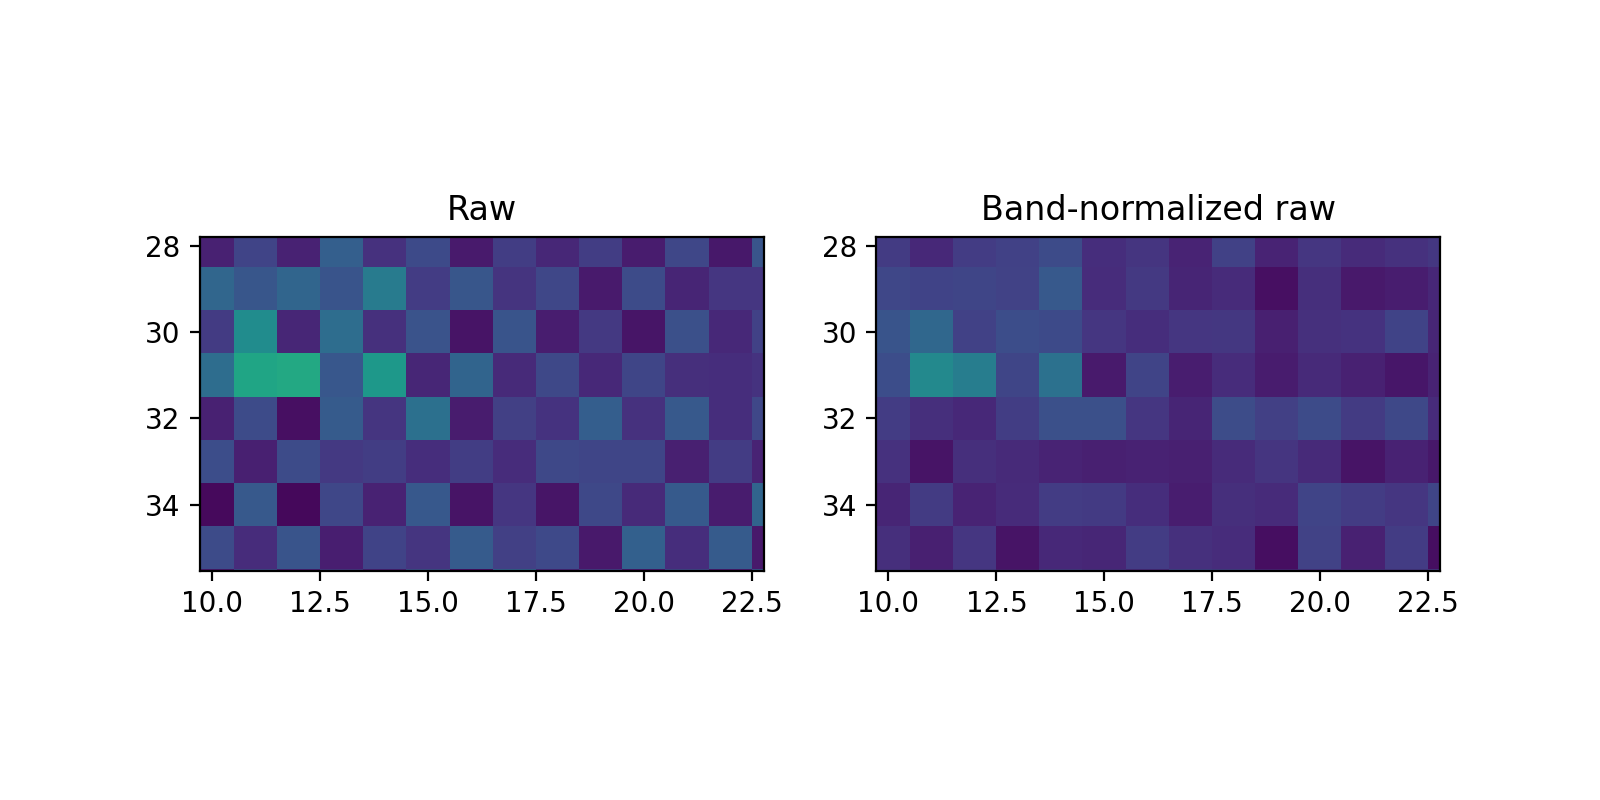

Text(0.5, 1.0, 'Band-normalized raw')

In [11]:
fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(imarray[1730:1770,630:670], vmax=2000)
plt.title("Raw")
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(raw_norm[1730:1770,630:670], vmax=2000)
plt.title("Band-normalized raw")

In [12]:
raw_norm = np.where(imarray > 16380, imarray, raw_norm)

<IPython.core.display.Javascript object>


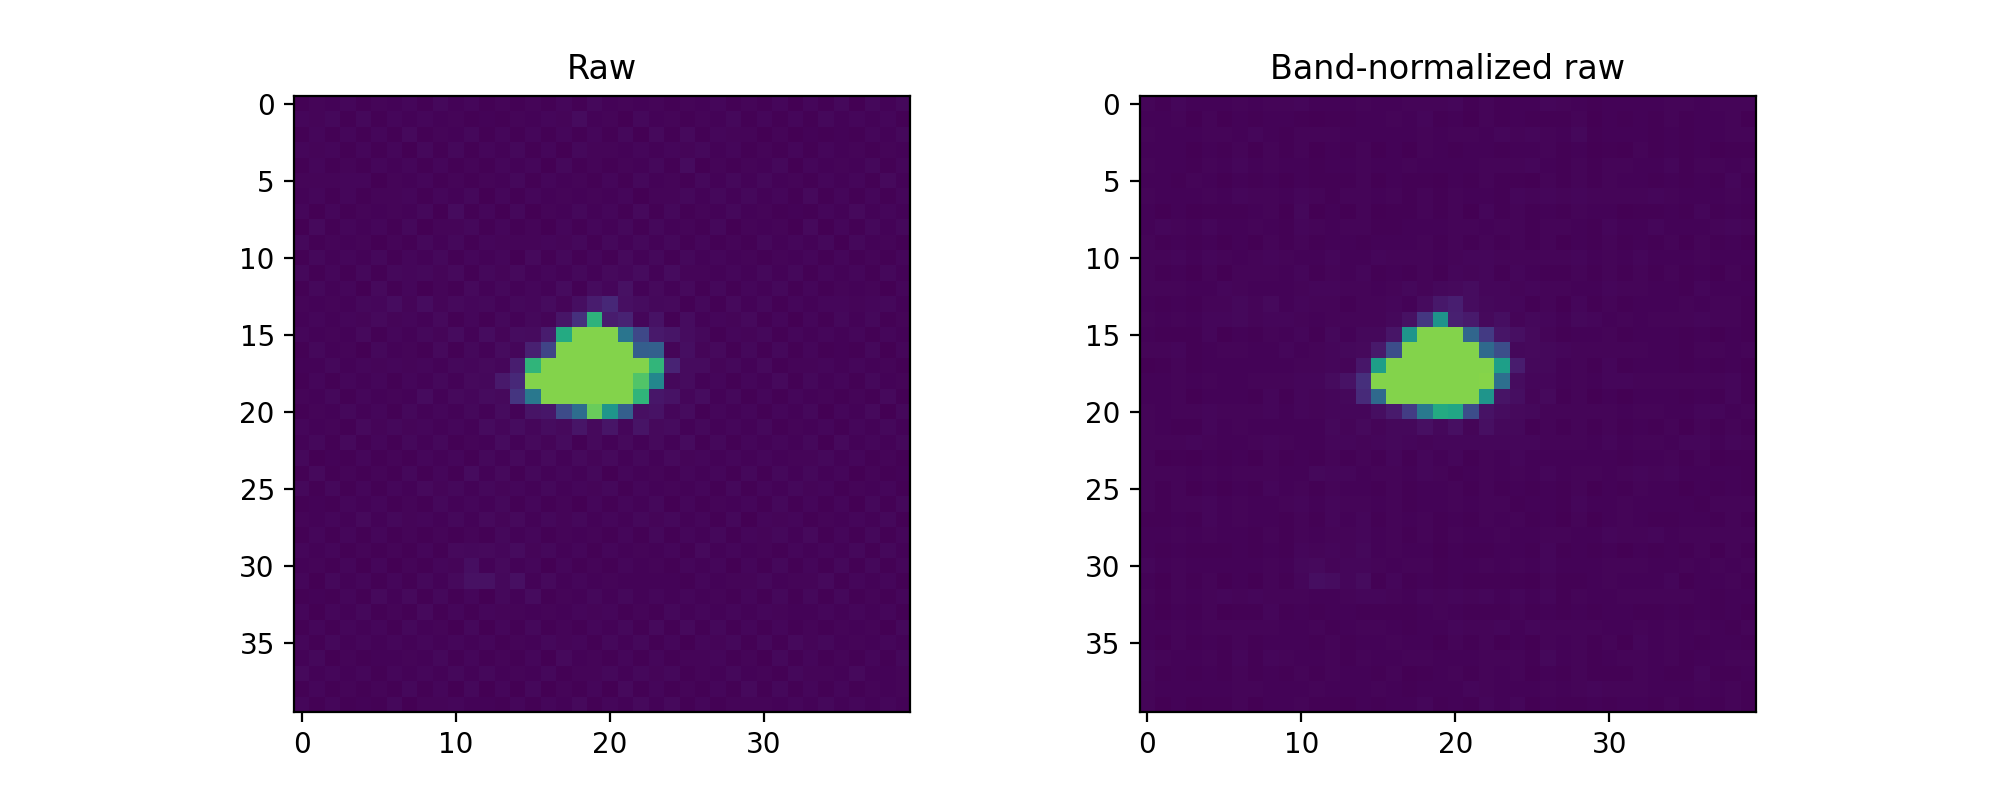

Text(0.5, 1.0, 'Band-normalized raw')

In [13]:
fig = plt.figure(figsize=[10, 4])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(imarray[1730:1770,630:670], vmax=20000)
plt.title("Raw")
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(raw_norm[1730:1770,630:670], vmax=20000)
plt.title("Band-normalized raw")

<IPython.core.display.Javascript object>


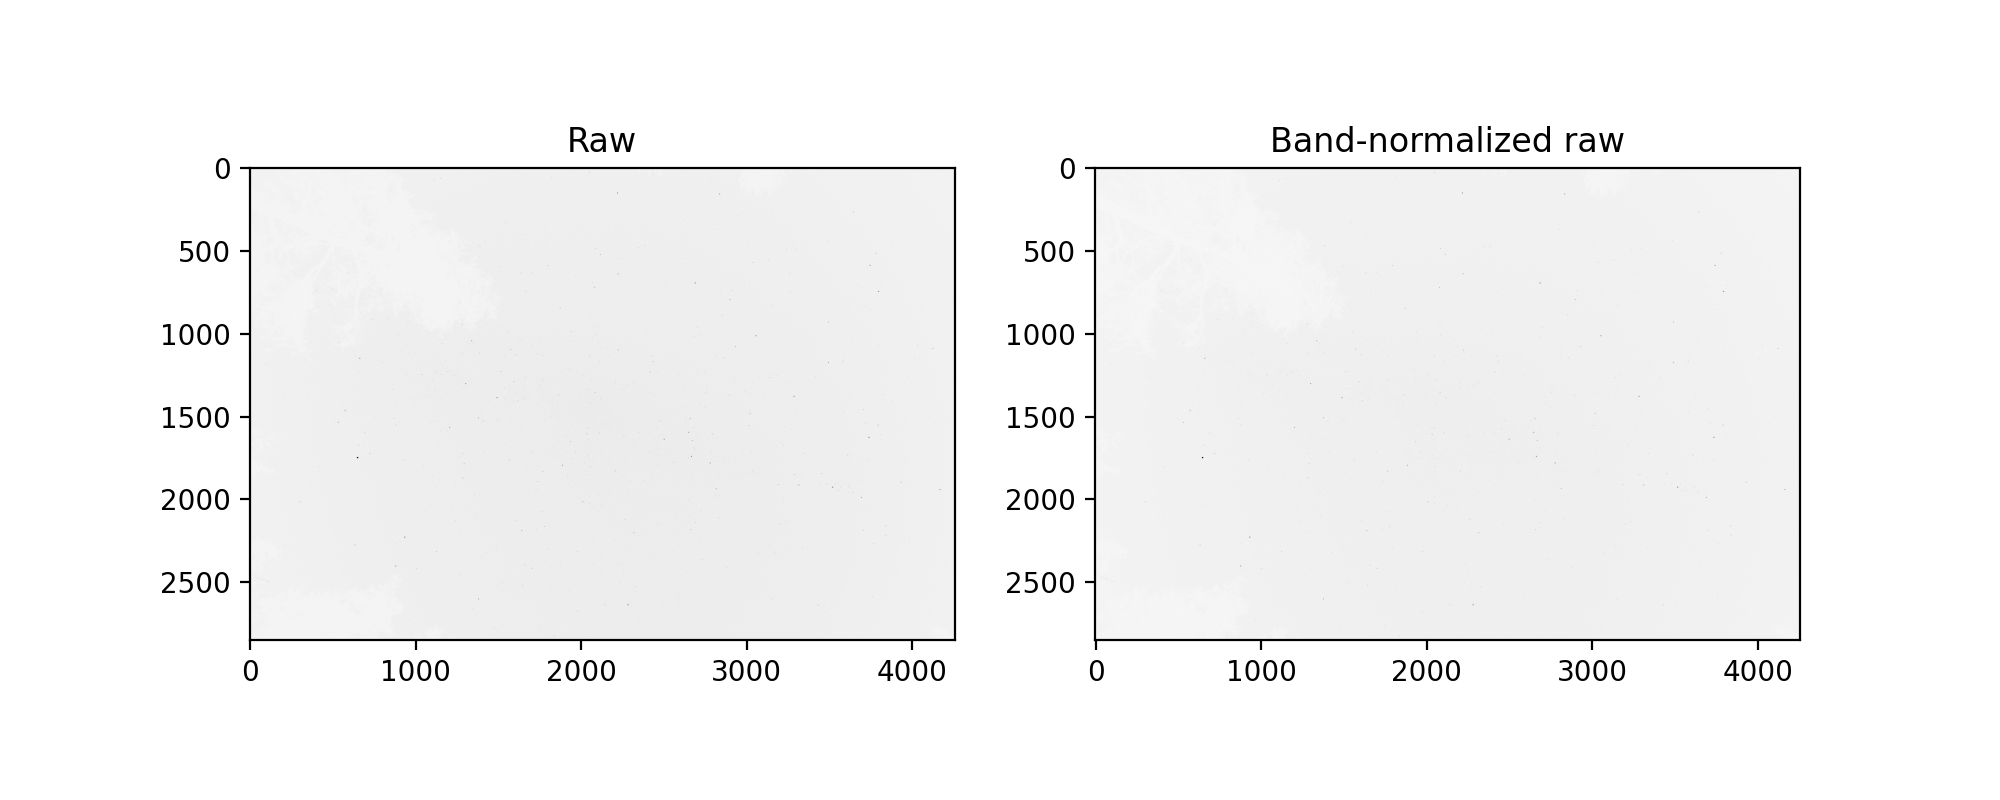

17917.76


In [14]:
fig = plt.figure(figsize=[10, 4])
ax = fig.add_subplot(1, 2, 1)
# plt.imshow(imarray[1800:2040,3400:3800], vmax=20000)
plt.imshow(imarray, vmax=12000, cmap='binary')
plt.title("Raw")
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(raw_norm, vmax=12000, cmap='binary')
plt.title("Band-normalized raw")
print(np.max(raw_norm))

## Handle flat field via median subtraction

The flat field is overcorrecting. While we work on fixing that, we can try to do background flattening via median subtraction. This is fine for star finding since we are not concerned with the diffuse regions. Just want to find peaks in the image, and the algorithms require that the background be well behaved.

In [15]:
from astropy.stats import SigmaClip
from photutils.background import MedianBackground

sigma_clip = SigmaClip(sigma=3.0)
bkg = MedianBackground(sigma_clip)
bkg_value = bkg(raw_norm)
print(bkg_value)  

693.5364800000001


In [16]:
raw_norm_bkg = raw_norm - bkg_value